# Run Log Charts

Notebook to develop chart based on daily run log

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import boto3
import os

## Read in data

In [2]:
# Read in from local
# raw_data_df = pd.read_csv('Workout log - DailyRunLog.csv')

# Read in data from s3
bucket = "jeremyruns.com"
file_name = "daily_run_log.csv"

s3 = boto3.client('s3') 
obj = s3.get_object(Bucket= bucket, Key= file_name) 
raw_data_df = pd.read_csv(obj['Body'])

print(f'Records read in: {raw_data_df.shape[0]}')
#raw_data_df.dtypes

Records read in: 3391


### Process data, create rolling average variables

In [3]:
df = raw_data_df.copy()

In [4]:
def preprocess_raw_df(df_) -> pd.DataFrame:
    """ Function to preprocess raw daily data """
    df_ = (df_
           .assign(Date=pd.to_datetime(df_["Date"]))  # Make Date a datetime object
           .assign(Miles=lambda x: df_['Miles'].fillna(0))  # Fill missing miles with 0
           .assign(MA_10day=df_['Miles'].rolling(window=10).mean())  # Create rolling averages
           .assign(MA_30day=df_['Miles'].rolling(window=30).mean())
           .sort_values('Date')
          )
    return df_

In [5]:
df = df.pipe(preprocess_raw_df)

In [6]:
df = df[df['Date'] < datetime.datetime.today()]

In [7]:
days_of_data = df.shape[0]
print(f'Days of data: {days_of_data}')
print(f'Years of data: {round(days_of_data/365.0,2)}')

total_miles_run = df["Miles"].sum()
print(f'Total miles run: {total_miles_run}')

Days of data: 3380
Years of data: 9.26
Total miles run: 4998.3


In [9]:
df['MA_10day'] = df['Miles'].rolling(window=10).mean()

In [11]:
df['MA_30day'] = df['Miles'].rolling(window=30).mean()

In [12]:
df.tail(10)

,Date,Miles,Notes,MA_10day,MA_30day
3370,2022-10-11,0.0,Ibiza,0.3,1.203333
3371,2022-10-12,0.0,Ibiza,0.3,1.203333
3372,2022-10-13,0.0,Ibiza,0.3,1.053333
3373,2022-10-14,0.0,Ibiza,0.3,1.053333
3374,2022-10-15,3.0,London park run,0.6,1.153333
3375,2022-10-16,0.0,London,0.6,1.020000
3376,2022-10-17,0.0,"lift legs, bike 40min",0.6,1.020000
3377,2022-10-18,4.0,treadmill 36min,0.7,1.153333
3378,2022-10-19,0.0,lift legs,0.7,1.020000
3379,2022-10-20,0.0,lift push,0.7,1.020000


### Calculate stats

In [13]:
def calc_runstats(df: pd.DataFrame, num_days_back):
    """
    
    Function to calculate stats from daily running dataframe
    
    :input: df: pd.DataFrame
    :return: dict
    """
    runstats_output = {}
    runstats_output['num_days_back'] = num_days_back
    num_days_run = sum(df.tail(num_days_back)['Miles']>0)
    runstats_output['num_days_run'] = num_days_run
    runstats_output['pct_days_run'] = round(100.0*num_days_run/num_days_back,1)
    tot_miles_run = round(df.tail(num_days_back)['Miles'].sum(),1)
    runstats_output['tot_miles_run'] = tot_miles_run
    runstats_output['miles_per_day'] = round(tot_miles_run/num_days_back,2)
    runstats_output['miles_per_run'] = round(tot_miles_run/num_days_run,2)
    return runstats_output

In [14]:
last_30_stats_dict = calc_runstats(df=df, num_days_back=30)
last_30_stats_dict

{'num_days_back': 30,
 'num_days_run': 8,
 'pct_days_run': 26.7,
 'tot_miles_run': 30.6,
 'miles_per_day': 1.02,
 'miles_per_run': 3.82}

In [15]:
def create_metrics_text_from_dict(metrics_dict):
    """
    Function to create text string from metrics dict
    """
    
    metrics_text_string = f"""Last {metrics_dict['num_days_back']} days: \
{metrics_dict['num_days_run']} runs, \
{metrics_dict['pct_days_run']}% of days, \
{metrics_dict['tot_miles_run']} miles, \
{metrics_dict['miles_per_day']} miles/day, \
{metrics_dict['miles_per_run']} miles/run\
"""
    
    return metrics_text_string

In [16]:
last_90_text = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=90))
print(last_90_text)

Last 90 days: 28 runs, 31.1% of days, 108.7 miles, 1.21 miles/day, 3.88 miles/run


In [17]:
def create_last_run_text(df):
    """ Function to create text about the most recent run from df """
    last_run_date = pd.Timestamp(df[df['Miles']>0].tail(1)['Date'].values[0])
    last_run_distance = df[df['Miles']>0].tail(1)['Miles'].values[0]
    last_run_notes = df[df['Miles']>0].tail(1)['Notes'].values[0]

    if pd.isnull(df[df['Miles']>0].tail(1)['Notes'].values[0]):
        last_run_text = f"Last Run: {last_run_date.strftime('(%m/%d)')} - {last_run_distance} miles"
    else:
        last_run_text = f"Last Run: {last_run_date.strftime('(%m/%d)')} - {last_run_distance} miles ({last_run_notes})"

    return last_run_text

In [18]:
last_run_text = create_last_run_text(df)
last_run_text

'Last Run: (10/18) - 4.0 miles (treadmill 36min)'

In [19]:
site_last_updated = datetime.datetime.now().strftime('(%m/%d)')
print(site_last_updated)

(10/20)


## Plot data

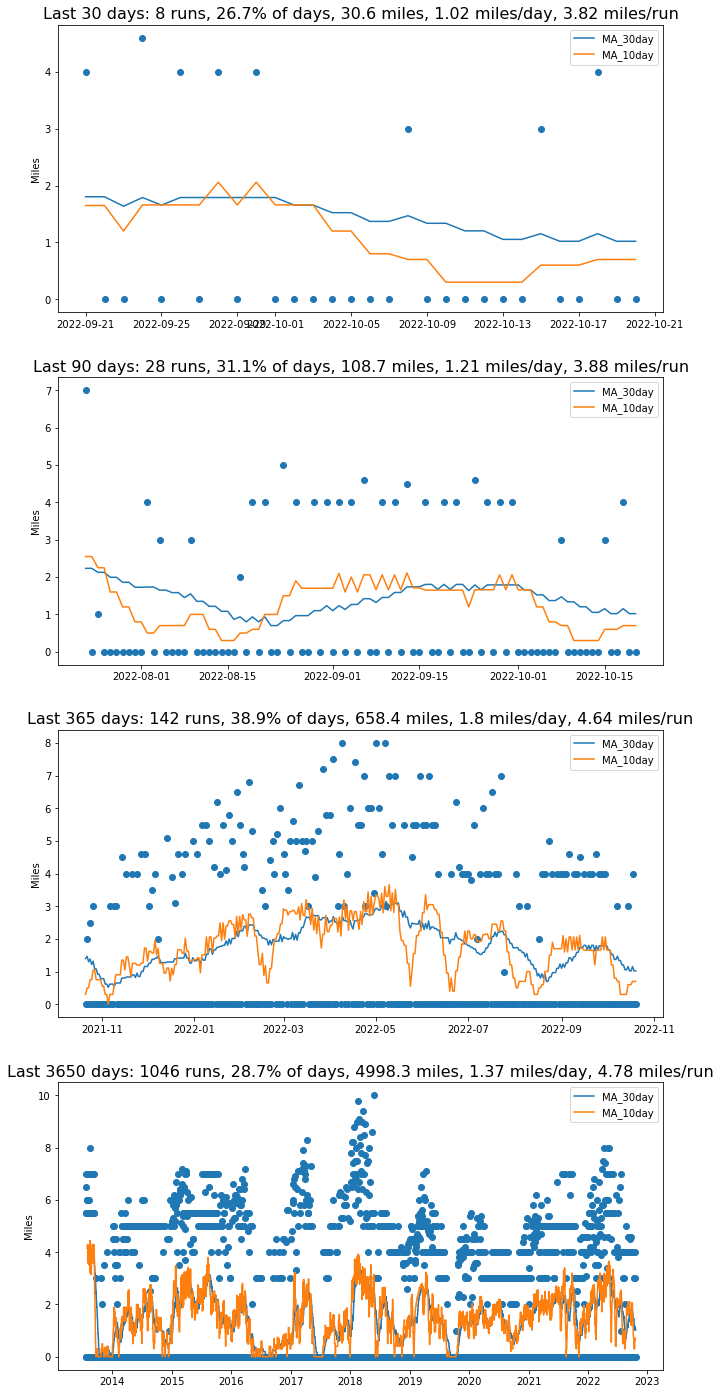

In [22]:
fig, ax = plt.subplots(4,1, figsize=(10,20))

days_back = 30
ax[0].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
ax[0].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
ax[0].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
ax[0].legend(['MA_30day', 'MA_10day'])
ax[0].set_ylabel('Miles')
text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
ax[0].set_title(f'{text_summary}')
ax[0].title.set_size(16)

days_back = 90
ax[1].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
ax[1].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
ax[1].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
ax[1].legend(['MA_30day', 'MA_10day'])
ax[1].set_ylabel('Miles')
text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
ax[1].set_title(f'{text_summary}')
ax[1].title.set_size(16)

days_back = 365
ax[2].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
ax[2].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
ax[2].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
ax[2].legend(['MA_30day', 'MA_10day'])
ax[2].set_ylabel('Miles')
text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
ax[2].set_title(f'{text_summary}')
ax[2].title.set_size(16)

days_back = 3650
ax[3].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
ax[3].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
ax[3].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
ax[3].legend(['MA_30day', 'MA_10day'])
ax[3].set_ylabel('Miles')
text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
ax[3].set_title(f'{text_summary}')
ax[3].title.set_size(16)

fig.tight_layout(pad = 3.0)

plt.savefig('all_charts.png')

plt.show()

In [23]:
def create_all_charts(df):
    """ Function to create all charts in one single png """
    
    fig, ax = plt.subplots(4,1, figsize=(10,20))

    days_back = 30
    ax[0].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
    ax[0].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
    ax[0].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
    ax[0].legend(['MA_30day', 'MA_10day'])
    ax[0].set_ylabel('Miles')
    text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
    ax[0].set_title(f'{text_summary}')
    ax[0].title.set_size(16)

    days_back = 90
    ax[1].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
    ax[1].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
    ax[1].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
    ax[1].legend(['MA_30day', 'MA_10day'])
    ax[1].set_ylabel('Miles')
    text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
    ax[1].set_title(f'{text_summary}')

    days_back = 365
    ax[2].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
    ax[2].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
    ax[2].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
    ax[2].legend(['MA_30day', 'MA_10day'])
    ax[2].set_ylabel('Miles')
    text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
    ax[2].set_title(f'{text_summary}')

    days_back = 3650
    ax[3].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_30day'])
    ax[3].plot(df.tail(days_back)['Date'],df.tail(days_back)['MA_10day'])
    ax[3].scatter(df.tail(days_back)['Date'],df.tail(days_back)['Miles'])
    ax[3].legend(['MA_30day', 'MA_10day'])
    ax[3].set_ylabel('Miles')
    text_summary = create_metrics_text_from_dict(calc_runstats(df=df, num_days_back=days_back))
    ax[3].set_title(f'{text_summary}')

    fig.tight_layout(pad = 3.0)

    fig.savefig('all_charts.png')

In [24]:
pwd

'C:\\Users\\jerem\\Desktop\\nonsense\\jeremyruns'

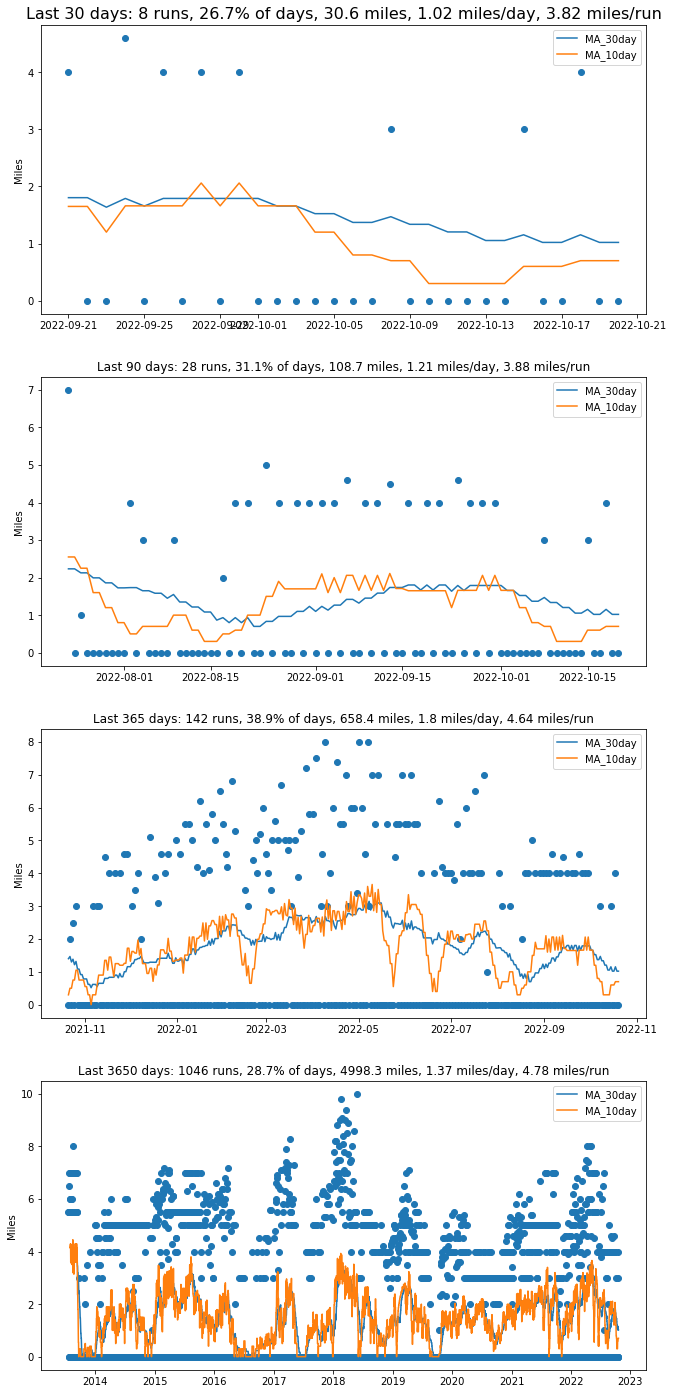

In [25]:
create_all_charts(df=df)

### Create html output for index

In [ ]:
style_text = """
<style>

h1 {text-align: center;}

.center {
  display: block;
  margin-left: auto;
  margin-right: auto;
  width: 50%;
}

</style>
"""

In [ ]:
html_string = f"""

<html xmlns="http://www.w3.org/1999/xhtml">
<head>
    <title>jeremyruns.com</title>
    <link rel="icon" type="image/png" href="https://s3.us-east-2.amazonaws.com/jeremyruns.com/favicon.png">
</head>

{style_text}

<body>
    <h1>JEREMYRUNS.COM</h1>

    <img src="https://s3.us-east-2.amazonaws.com/jeremyruns.com/all_charts.png" class="center">

    <h4>{last_run_text}</h4>

    <h4>Updated as of {site_last_updated}</h4>

    <p></p>

    <a href="https://jeremyruns.com/jeremyruns_architecture.html">Site Architecture Diagram</a>

    <p></p>

    <a href="https://github.com/jeremypmobley/nonsense/tree/master/jeremyruns">GitHub Code Repo</a>

</body>
</html>

"""

#### Write out index.html file local

In [ ]:
pwd

In [ ]:
# Creating an HTML file
html_file = open("index.html","w")

# Adding input data to the HTML file
html_file.write(html_string)

# Saving the data into the HTML file
html_file.close()

### Write files to s3 bucket

In [ ]:
s3_client = boto3.resource('s3')
bucket = s3_client.Bucket('jeremyruns.com')

In [ ]:
# index file
bucket.upload_file('index.html', 'index.html', ExtraArgs={'ContentType': 'text/html'})

In [ ]:
# all_charts
bucket.upload_file(f'all_charts.png', f'all_charts.png',
                               ExtraArgs={'ContentType': 'image/png'})